This notebook provides code to analyze the events of 27 March 2017. Three distinct convective modes had pass through the CLAMPS deployment site on this day, making this event a unique set of observations that require its own code to visualize.

In [1]:
#Supress Warnings
import warnings
warnings.filterwarnings("ignore")

from utils import integral_ts

import numpy as np
import pickle
import cmocean
from datetime import datetime
import scipy.signal as sig
from scipy.ndimage import gaussian_filter
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator
import matplotlib.dates as mdates

#Import the case dictionaries
f = open('clamps_cases.pckl', 'rb')
lin,dis,mix = pickle.load(f)
f.close()

l_height = 2500 #m
l_height_barb = 1500 #m 2500

plt.rcParams.update({'font.size':25,'font.family':'Arial'})

#Set these parameters 



In [2]:
#Print out all case dates to pick the index corresponding to 27 March 2017
data = lin
print('Linear')
[print('{}: {}'.format(k,data[k]['date'].strftime('%d %B %Y'))) for k in range(len(data))]
print()

data = dis
print('Discrete')
[print('{}: {}'.format(k,data[k]['date'].strftime('%d %B %Y'))) for k in range(len(data))]
print()

data = mix
print('Mixed')
[print('{}: {}'.format(k,data[k]['date'].strftime('%d %B %Y'))) for k in range(len(data))]
print()

Linear
0: 10 March 2017
1: 28 March 2017

Discrete
0: 27 March 2017
1: 05 April 2017
2: 07 April 2019
3: 01 April 2016
4: 30 April 2016

Mixed
0: 01 March 2017
1: 21 March 2017
2: 27 March 2017
3: 22 April 2017
4: 09 March 2019



In [3]:
#Concatentate all the data for the single day
l,m,d = lin[1],mix[2],dis[0]

#Index where the second mode begins in the first mode time series
d_m = np.where(d['t_dec']==m['t_dec'][0])[0][0]
m_l = np.where(m['t_dec']==l['t_dec'][0])[0][0]

t_height = l['t_height']
l_height = l['l_height']

#Combine the time
t_dec = np.concatenate((d['t_dec'][:d_m],m['t_dec'][:m_l],l['t_dec'][:]))
l_dec = np.concatenate((d['l_dec'][:d_m],m['l_dec'][:m_l],l['l_dec'][:]))

t_utc = np.concatenate((d['t_utc'][:d_m],m['t_utc'][:m_l],l['t_utc'][:]))
l_utc = np.concatenate((d['l_utc'][:d_m],m['l_utc'][:m_l],l['l_utc'][:]))

#Combine thermodynamic variables
temp = np.concatenate((d['temp'][:d_m],m['temp'][:m_l],l['temp'][:]))
th = np.concatenate((d['theta'][:d_m],m['theta'][:m_l],l['theta'][:]))
pres = np.concatenate((d['pres'][:d_m],m['pres'][:m_l],l['pres'][:]))
dew = np.concatenate((d['dew'][:d_m],m['dew'][:m_l],l['dew'][:]))
qv = np.concatenate((d['qv'][:d_m],m['qv'][:m_l],l['qv'][:]))
sbcape = np.concatenate((d['sbcape'][:d_m],m['sbcape'][:m_l],l['sbcape'][:]))
cbh = np.concatenate((d['cbh'][:d_m],m['cbh'][:m_l],l['cbh'][:]))
sbcape2d = np.concatenate((d['sbcape_2d'][:d_m],m['sbcape_2d'][:m_l],l['sbcape_2d'][:]))

#Combine kinematic variables
wspd = np.concatenate((d['wspd'][:d_m],m['wspd'][:m_l],l['wspd'][:]))
u = np.concatenate((d['u'][:d_m],m['u'][:m_l],l['u'][:]))
v = np.concatenate((d['v'][:d_m],m['v'][:m_l],l['v'][:]))
sh01 = np.concatenate((d['mag01'][:d_m],m['mag01'][:m_l],l['mag01'][:]))
sh03 = np.concatenate((d['mag03'][:d_m],m['mag03'][:m_l],l['mag03'][:]))
sh13 = np.concatenate((d['mag13'][:d_m],m['mag13'][:m_l],l['mag13'][:]))
vs_utc = np.concatenate((d['vs_utc'][:d_m],m['vs_utc'][:m_l],l['vs_utc'][:]))
vs_height = np.concatenate((d['vs_height'][:d_m],m['vs_height'][:m_l],l['vs_height'][:]))
w = np.concatenate((d['w'][:d_m],m['w'][:m_l],l['w'][:]))

#Replace the x-axis with its UTC timestep
timestamp=[]
for k in range(len(t_utc)):
    timestamp.append(datetime.utcfromtimestamp(t_utc[k]))

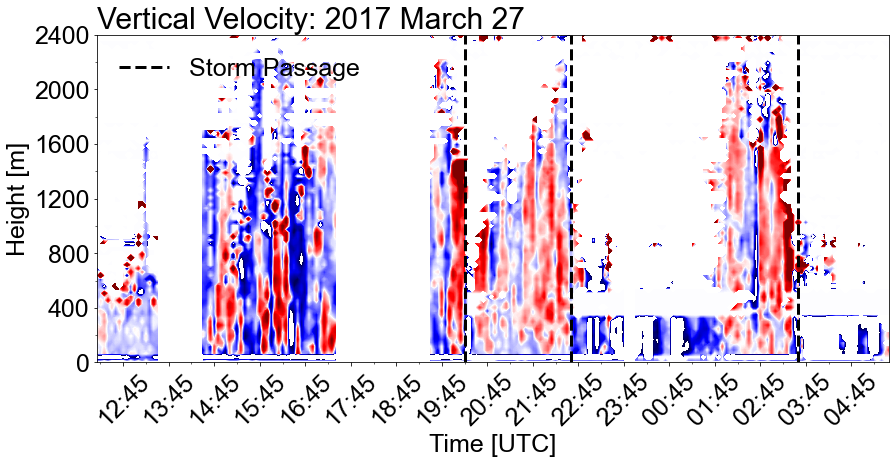

In [4]:
#######################################################
#Plot the vertical velocity from the vertical stare
#######################################################

hidx = np.where(l_height>=2500)[0][0]
height_plot = l_height[:hidx]

#Use this to append to the dataframe 
timestamp=[]
for k in range(len(l_utc)):
    timestamp.append(datetime.utcfromtimestamp(l_utc[k]))
    
#Try to make the data gaps all nans so they do not get smoothed over
df = pd.DataFrame(w[:,:hidx])
df.set_index(np.array(timestamp),inplace=True)
df = df.resample('5T').first().fillna(value=np.nan)
w_plot1 = df.values.T

df.reset_index(inplace=True)
timestamp = df['index'].values
    
passage_timestamp_d = dis[0]['passage_time']
passage_timestamp_m = mix[2]['passage_time']
passage_timestamp_l = lin[1]['passage_time']

#Format the colorbar
levs = np.linspace(-1,1,256,endpoint=True)
norm = mpl.colors.BoundaryNorm(levs,256)

#Plot the data
plt.figure(figsize=(13,7))
ax = plt.subplot(1,1,1)
ax.set_title('Vertical Velocity: {}'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y %B %d')),loc='left')

X,Y = np.meshgrid(timestamp,height_plot)
color_map = plt.cm.get_cmap('seismic')
plot = ax.contourf(X,Y,w_plot1,cmap=color_map,norm=norm,levels=levs,extend='max')
plot.cmap.set_under('grey') #Grey undertones for bad data

ax.axvline(x=passage_timestamp_d,linestyle='dashed',color='k',label='Storm Passage',linewidth=3)
ax.axvline(x=passage_timestamp_m,linestyle='dashed',color='k',linewidth=3)
ax.axvline(x=passage_timestamp_l,linestyle='dashed',color='k',linewidth=3)

#Format axes
ax.set_xlabel('Time [UTC]')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.set_ylabel('Height [m]')
ax.yaxis.set_major_locator(MultipleLocator(400))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(200))

ax.set_ylim((0,2400)) 
ax.set_xlim(timestamp[0],timestamp[-1])

#Legend
ax.legend(framealpha=0.0,loc='upper left')

plt.tight_layout()
#plt.savefig('figures/20170327/vert_vel_{}.jpg'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y%m%d')),dpi=300,bbox_inches='tight')
plt.show()
plt.close()


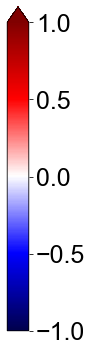

In [5]:
#Colorbar stuff
fig = plt.figure(figsize=(10,10))

ticks = np.linspace(-1,1,5,endpoint=True)
rad_cax = fig.add_axes([0.15, 0.05, 0.03, 0.45]) #zonal, vertical, width, length
rad_cb = plt.colorbar(plot,ticks=ticks,cax=rad_cax,norm=norm,orientation='vertical')
rad_cax.yaxis.set_ticks_position('right')
#rad_cax.yaxis.set_label_position('right')
#rad_cb.set_label(label='m $s^{-1}$')

#plt.savefig('figures/20170327/vert_vel_colorbar.png',dpi=300,bbox_inches='tight')

plt.show()

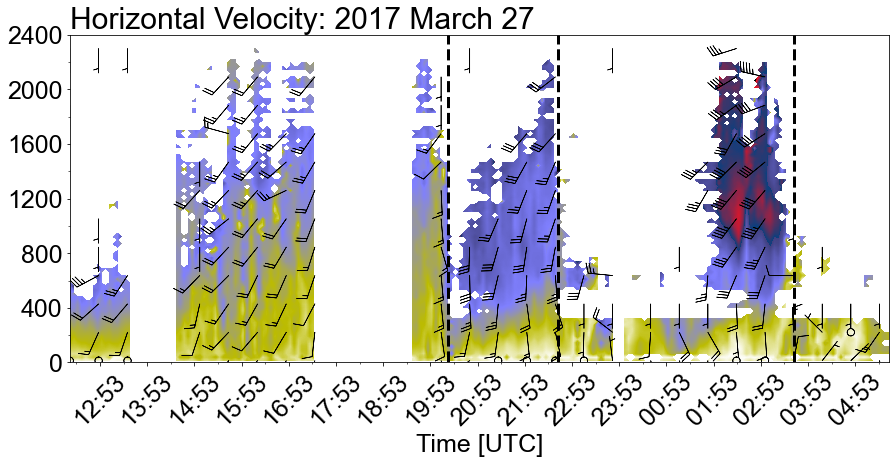

In [6]:
#######################################################
#Plot the horizontal wind speed with wind barbs
#######################################################

hidx = np.where(l_height>=2500)[0][0]
height_plot = l_height[:hidx]

#Use this to append to the dataframe 
timestamp=[]
for k in range(len(l_utc)):
    timestamp.append(datetime.utcfromtimestamp(l_utc[k]))
    
#Try to make the data gaps all nans so they do not get smoothed over
df = pd.DataFrame(wspd[:,:hidx])
df.set_index(np.array(timestamp),inplace=True)
df = df.resample('5T').first().fillna(value=np.nan)
wspd_plot1 = df.values.T

df.reset_index(inplace=True)
timestamp = df['index'].values

passage_timestamp_d = dis[0]['passage_time']
passage_timestamp_m = mix[2]['passage_time']
passage_timestamp_l = lin[1]['passage_time']

#Get the data to plot and filter
u_plot = u[:,:hidx]
v_plot = v[:,:hidx]

wspd_plot1[wspd_plot1<=0] = np.nan
wspd_plot1[wspd_plot1==2.0000002] = np.nan

u[u==-9999] = np.nan
v[v==-9999] = np.nan


#Format the colorbar
levs = np.linspace(0,25,256,endpoint=True)
norm = mpl.colors.BoundaryNorm(levs,256)

#Plot the data
plt.figure(figsize=(13,7))
ax = plt.subplot(1,1,1)
ax.set_title('Horizontal Velocity: {}'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y %B %d')),loc='left')

X,Y = np.meshgrid(timestamp,height_plot)
color_map = plt.cm.get_cmap('gist_stern')
plot = ax.contourf(X,Y,wspd_plot1,cmap=color_map.reversed(),norm=norm,levels=levs,extend='max')
plot.cmap.set_under('grey') #Grey undertones for bad data

ax.axvline(x=passage_timestamp_d,linestyle='dashed',color='k',label='Storm Passage',linewidth=3)
ax.axvline(x=passage_timestamp_m,linestyle='dashed',color='k',linewidth=3)
ax.axvline(x=passage_timestamp_l,linestyle='dashed',color='k',linewidth=3)

#Plot the wind barbs
time_incre = 12 #10
height_incre = 8 #10

#Use this to append to the dataframe 
timestamp=[]
for k in range(len(l_utc)):
    timestamp.append(datetime.utcfromtimestamp(l_utc[k]))

x,y = np.meshgrid(timestamp[::time_incre],height_plot[::height_incre])
u_plot2 = u_plot[::time_incre,::height_incre] * 1.943844 #knots
v_plot2 = v_plot[::time_incre,::height_incre] * 1.943844 #knots
barb = ax.barbs(x,y,u_plot2.transpose(),v_plot2.transpose(),length=7,linewidth=0.7)

#Format axes
ax.set_xlabel('Time [UTC]')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

#ax.set_ylabel('Height [m]')
ax.yaxis.set_major_locator(MultipleLocator(400))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(200))

ax.set_ylim((0,2400)) 
ax.set_xlim(timestamp[0],timestamp[-1])

#Legend
#ax.legend(framealpha=0.0,loc='upper left')

plt.tight_layout()
#plt.savefig('figures/20170327/horiz_vel_{}.jpg'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y%m%d')),dpi=300,bbox_inches='tight')
plt.show()
plt.close()


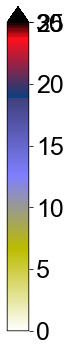

In [7]:
#Colorbar stuff
fig = plt.figure(figsize=(10,10))

ticks = np.arange(0,35,5)
rad_cax = fig.add_axes([0.15, 0.05, 0.03, 0.45]) #zonal, vertical, width, length
rad_cb = plt.colorbar(plot,ticks=ticks,cax=rad_cax,norm=norm,orientation='vertical')
rad_cax.yaxis.set_ticks_position('right')
#rad_cax.yaxis.set_label_position('right')
#rad_cb.set_label(label='m $s^{-1}$')

#plt.savefig('figures/20170327/horiz_vel_colorbar.png',dpi=300,bbox_inches='tight')

plt.show()

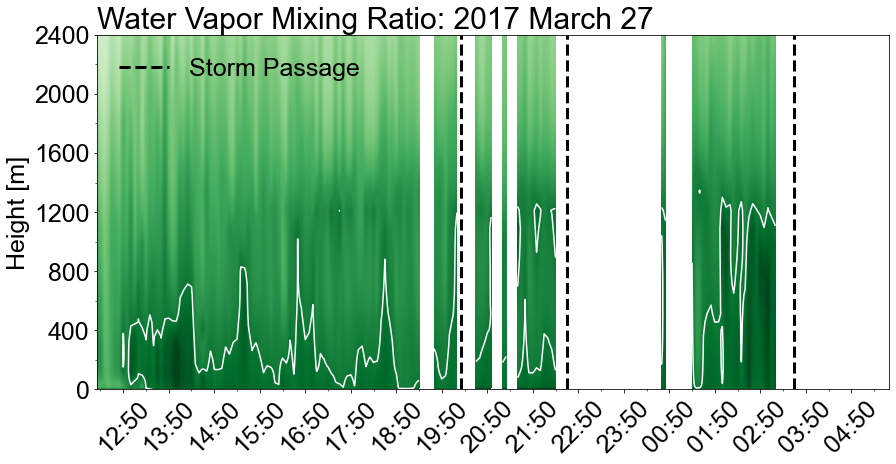

In [8]:
#######################################################
#Plot water vapor mixing ratio
#######################################################

hidx = np.where(t_height>=2500)[0][0]
height_plot = t_height[:hidx]

#Use this to append to the dataframe 
timestamp=[]
for k in range(len(t_utc)):
    timestamp.append(datetime.utcfromtimestamp(t_utc[k]))
    
#Try to make the data gaps all nans so they do not get smoothed over
df = pd.DataFrame(qv[:,:hidx])
df.set_index(np.array(timestamp),inplace=True)
df = df.resample('5T').first().fillna(value=np.nan)
qv_plot1 = df.values.T

df.reset_index(inplace=True)
timestamp = df['index'].values

passage_timestamp_d = dis[0]['passage_time']
passage_timestamp_m = mix[2]['passage_time']
passage_timestamp_l = lin[1]['passage_time']

#Format the colorbar
levs = np.linspace(0,12,256,endpoint=True)
norm = mpl.colors.BoundaryNorm(levs,256)

#Plot the data
plt.figure(figsize=(13,7))
ax = plt.subplot(1,1,1)
ax.set_title('Water Vapor Mixing Ratio: {}'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y %B %d')),loc='left')

X,Y = np.meshgrid(timestamp,height_plot)
color_map = plt.cm.get_cmap('Greens')
plot = ax.contourf(X,Y,qv_plot1,cmap=color_map,norm=norm,levels=levs,extend='max')
contours = ax.contour(X,Y,qv_plot1,levels=[10],colors='white')
#ax.clabel(contours,fmt='%1.0f')

ax.axvline(x=passage_timestamp_d,linestyle='dashed',color='k',label='Storm Passage',linewidth=3)
ax.axvline(x=passage_timestamp_m,linestyle='dashed',color='k',linewidth=3)
ax.axvline(x=passage_timestamp_l,linestyle='dashed',color='k',linewidth=3)

#Format axes
#ax.set_xlabel('Time [UTC]')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.set_ylabel('Height [m]')
ax.yaxis.set_major_locator(MultipleLocator(400))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(200))

ax.set_ylim((0,2400)) 
ax.set_xlim(timestamp[0],timestamp[-1])

#Legend
ax.legend(framealpha=0.0,loc='upper left')

plt.tight_layout()
#plt.savefig('figures/20170327/wvmr_{}.jpg'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y%m%d')),dpi=300,bbox_inches='tight')
plt.show()
plt.close()


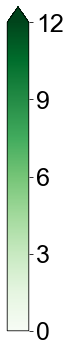

In [9]:
#Colorbar stuff
fig = plt.figure(figsize=(10,10))

ticks = np.arange(0,13,3)
rad_cax = fig.add_axes([0.15, 0.05, 0.03, 0.45]) #zonal, vertical, width, length
rad_cb = plt.colorbar(plot,ticks=ticks,cax=rad_cax,norm=norm,orientation='vertical')
rad_cax.yaxis.set_ticks_position('right')
#rad_cax.yaxis.set_label_position('right')
#rad_cb.set_label(label='g $kg^{-1}$')

#plt.savefig('figures/20170327/wvmr_colorbar.png',dpi=300,bbox_inches='tight')

plt.show()

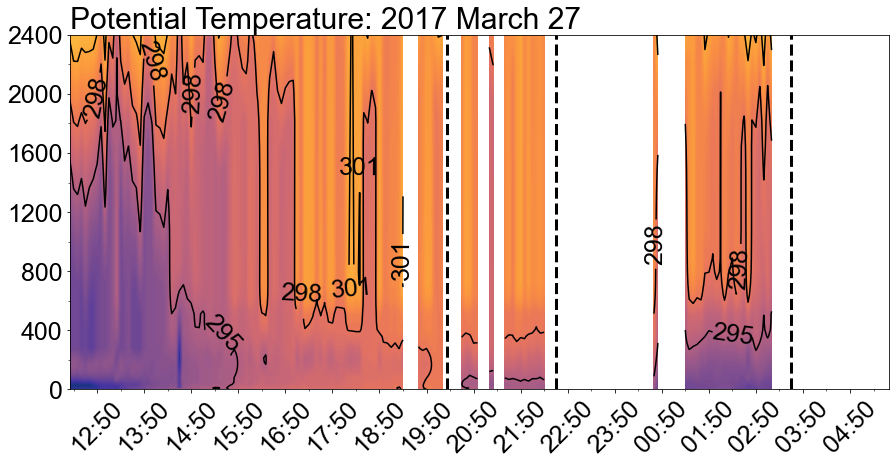

In [10]:
#######################################################
#Plot potential temperature
#######################################################

hidx = np.where(t_height>=2500)[0][0]
height_plot = t_height[:hidx]

#Use this to append to the dataframe 
timestamp=[]
for k in range(len(t_utc)):
    timestamp.append(datetime.utcfromtimestamp(t_utc[k]))
    
#Try to make the data gaps all nans so they do not get smoothed over
df = pd.DataFrame(th[:,:hidx])
df.set_index(np.array(timestamp),inplace=True)
df = df.resample('5T').first().fillna(value=np.nan)
th_plot1 = df.values.T

df.reset_index(inplace=True)
timestamp = df['index'].values

passage_timestamp_d = dis[0]['passage_time']
passage_timestamp_m = mix[2]['passage_time']
passage_timestamp_l = lin[1]['passage_time']

#Format the colorbar
levs = np.linspace(285,305,100,endpoint=True)
norm = mpl.colors.BoundaryNorm(levs,256)

#Plot the data
plt.figure(figsize=(13,7))
ax = plt.subplot(1,1,1)
ax.set_title('Potential Temperature: {}'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y %B %d')),loc='left')

X,Y = np.meshgrid(timestamp,height_plot)
color_map = cmocean.cm.thermal
#plot = ax.contourf(X,Y,th_plot1*(1+(0.61*(qv_plot1/1000))),cmap=color_map,norm=norm,levels=levs,extend='max')
plot = ax.contourf(X,Y,th_plot1,cmap=color_map,norm=norm,levels=levs,extend='max')
contours = ax.contour(X,Y,th_plot1,levels=np.arange(295,310,3),colors='k')
ax.clabel(contours,fmt='%1.0f')

ax.axvline(x=passage_timestamp_d,linestyle='dashed',color='k',label='Storm Passage',linewidth=3)
ax.axvline(x=passage_timestamp_m,linestyle='dashed',color='k',linewidth=3)
ax.axvline(x=passage_timestamp_l,linestyle='dashed',color='k',linewidth=3)

#Format axes
#ax.set_xlabel('Time [UTC]')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

#ax.set_ylabel('Height [m]')
ax.yaxis.set_major_locator(MultipleLocator(400))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(200))

ax.set_ylim((0,2400)) 
ax.set_xlim(timestamp[0],timestamp[-1])

#Legend
#ax.legend(framealpha=0.0,loc='upper left')

plt.tight_layout()
#plt.savefig('figures/20170327/th_{}.jpg'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y%m%d')),dpi=300,bbox_inches='tight')
plt.show()
plt.close()


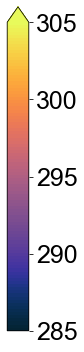

In [11]:
#Colorbar stuff
fig = plt.figure(figsize=(10,10))

ticks = np.arange(285,310,5)
rad_cax = fig.add_axes([0.15, 0.05, 0.03, 0.45]) #zonal, vertical, width, length
rad_cb = plt.colorbar(plot,ticks=ticks,cax=rad_cax,norm=norm,orientation='vertical')
rad_cax.yaxis.set_ticks_position('right')
#rad_cax.yaxis.set_label_position('right')
#rad_cb.set_label(label=r'K')

#plt.savefig('figures/20170327/th_colorbar.png',dpi=300,bbox_inches='tight')

plt.show()

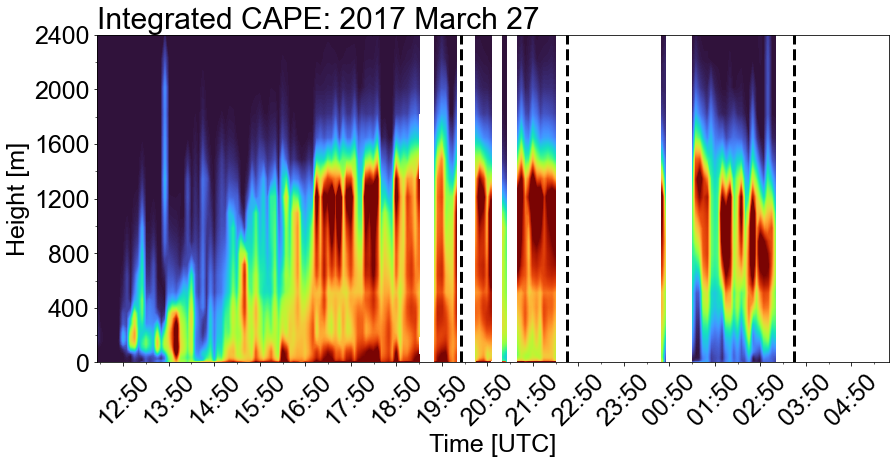

In [12]:
#######################################################
#Plot the integrated CAPE
#######################################################

hidx = np.where(t_height>=3000)[0][0]
height_plot = t_height[:hidx]

#Use this to append to the dataframe 
timestamp=[]
for k in range(len(t_utc)):
    timestamp.append(datetime.utcfromtimestamp(t_utc[k]))
    
#Try to make the data gaps all nans so they do not get smoothed over
df = pd.DataFrame(sbcape2d)
df.set_index(np.array(timestamp),inplace=True)
df = df.resample('5T').first().fillna(value=np.nan)
sbcape2d_plot1 = df.values.T

df.reset_index(inplace=True)
timestamp = df['index'].values

passage_timestamp_d = dis[0]['passage_time']
passage_timestamp_m = mix[2]['passage_time']
passage_timestamp_l = lin[1]['passage_time']

#Format the colorbar
levs = np.linspace(0,1500,256,endpoint=True)
norm = mpl.colors.BoundaryNorm(levs,256)

#Plot the data
plt.figure(figsize=(13,7))
ax = plt.subplot(1,1,1)
ax.set_title('Integrated CAPE: {}'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y %B %d')),loc='left')

X,Y = np.meshgrid(timestamp,height_plot)
color_map = plt.get_cmap('turbo')
plot = ax.contourf(X,Y,sbcape2d_plot1,cmap=color_map,norm=norm,levels=levs,extend='max')

ax.axvline(x=passage_timestamp_d,linestyle='dashed',color='k',label='Storm Passage',linewidth=3)
ax.axvline(x=passage_timestamp_m,linestyle='dashed',color='k',linewidth=3)
ax.axvline(x=passage_timestamp_l,linestyle='dashed',color='k',linewidth=3)

#Format axes
ax.set_xlabel('Time [UTC]')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.set_ylabel('Height [m]')
ax.yaxis.set_major_locator(MultipleLocator(400))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(200))

ax.set_ylim((0,2400)) 
ax.set_xlim(timestamp[0],timestamp[-1])

plt.tight_layout()
#plt.savefig('figures/20170327/sbcape_2d_{}.jpg'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y%m%d')),dpi=300,bbox_inches='tight')
plt.show()
plt.close()


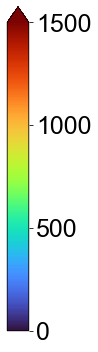

In [13]:
#Colorbar stuff
fig = plt.figure(figsize=(10,10))

ticks = np.arange(0,2000,500)
rad_cax = fig.add_axes([0.15, 0.05, 0.03, 0.45]) #zonal, vertical, width, length
rad_cb = plt.colorbar(plot,ticks=ticks,cax=rad_cax,norm=norm,orientation='vertical')
rad_cax.yaxis.set_ticks_position('right')
rad_cax.yaxis.set_label_position('right')
#rad_cb.set_label(label=r'J $kg^{-1}$')

#plt.savefig('figures/20170327/sbcape2d_colorbar.png',dpi=300,bbox_inches='tight')

plt.show()

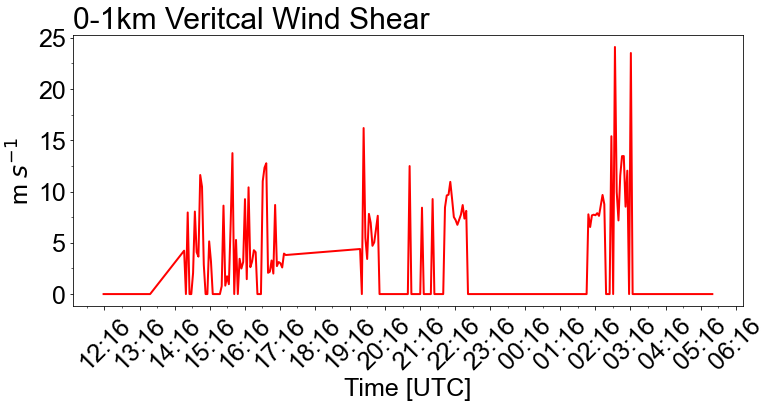

In [14]:
#######################################################
#Plot time series of vertical shear
#######################################################

timestamp=[]
for k in range(len(l_utc)):
    timestamp.append(datetime.utcfromtimestamp(l_utc[k]))
    
plt.figure(figsize=(12,5))
plt.title('0-1km Veritcal Wind Shear',loc='left')

ax = plt.subplot(1,1,1)
#ax.plot(timestamp,sh01,color='blue',linewidth=2,linestyle='solid',label='0-1km Shear')
ax.plot(timestamp,sh03,color='red',linewidth=2,linestyle='solid',label='0-3km Shear')
#ax.plot(timestamp,sh13,color='green',linewidth=2,linestyle='solid',label='1-3km Shear')

#Format the axes
ax.set_xlabel('Time [UTC]')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.set_ylabel('m $s^{-1}$')
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(2.5))

plt.show()
plt.close()

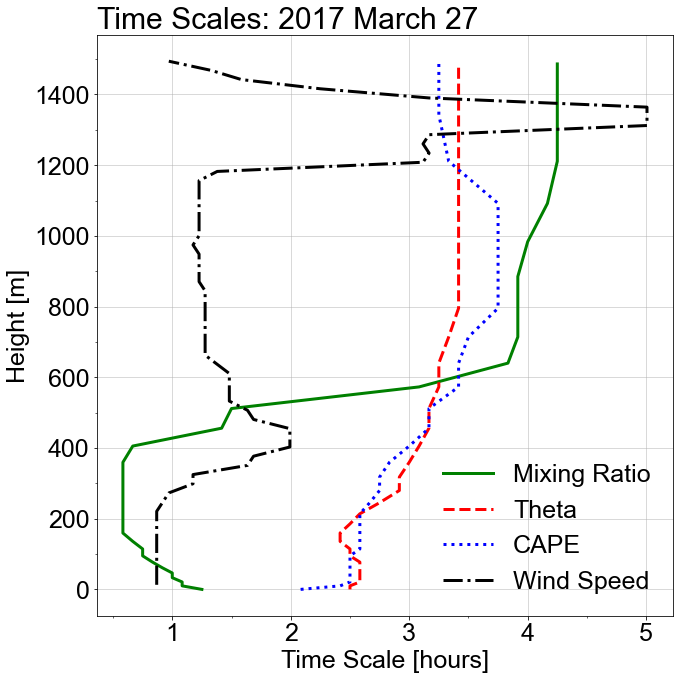

In [15]:
#######################################################
#Compute the integral time scale of all features
#######################################################

plt.rcParams.update({'font.size':25})
plt.figure(figsize=(10,10))
plt.grid(alpha=0.6)
ax = plt.subplot(1,1,1)
ax.set_title('Time Scales: {}'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y %B %d')),loc='left')

h1 = np.where(t_height>=1500)[0][0]
h2 = np.where(l_height>=1500)[0][0]

#Plot qv
lag_data,efolding_time = integral_ts(qv,(t_utc - t_utc[0])/3600,t_height[:h1])
ax.plot(lag_data,t_height[:h1],color='green',label='Mixing Ratio',linewidth=3,linestyle='solid')

#plot theta
lag_data,efolding_time = integral_ts(th*(1+(0.61*(qv/1000))),(t_utc - t_utc[0])/3600,t_height[:h1])
ax.plot(lag_data,t_height[:h1],color='red',label='Theta',linewidth=3,linestyle='dashed')

#plot CAPE
lag_data,efolding_time = integral_ts(sbcape2d,(t_utc - t_utc[0])/3600,t_height[:h1])
ax.plot(lag_data,t_height[:h1],color='blue',label='CAPE',linewidth=3,linestyle='dotted')

#plot wspd
lag_data,efolding_time = integral_ts(wspd,(l_utc - l_utc[0])/3600,l_height[:h2])
ax.plot(sig.medfilt(lag_data,9),l_height[:h2],color='k',label='Wind Speed',linewidth=3,linestyle='dashdot')

#Format axes
ax.set_ylabel('Height [m]')
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(100))


ax.set_xlabel('Time Scale [hours]')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

#legend
ax.legend(framealpha=0.0,loc='lower right')

plt.tight_layout()
#plt.savefig('figures/20170327/time_scales_{}.jpg'.format(datetime.strptime(str(dis[0]['date']),'%Y-%m-%d %H:%M:%S').strftime('%Y%m%d')),dpi=300,bbox_inches='tight')
plt.show()
plt.close()